In [1427]:
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier
from sklearn import datasets

from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt


def calculate_ridge(X_param, y_param, k):
    return np.linalg.pinv((X_param.T @ X_param) + (k * np.identity(len(X_param.T)))) @ (X_param.T @ y_param) * 2


def my_normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))


def f_wielomian(w, x):
    x = np.c_[np.ones((x.shape[0], 1)), x]
    y = np.sum(x @ w, axis=1)
    return y


def normal_equation_ridge_regression(X_param, y_param, alpha):
    intercept_ones = np.ones((len(X_param), 1))        # results in array( [ [1],..,[1] ] )
    X_b = np.c_[intercept_ones, X_param]               # we now add the additional ones as a new column to our X
    I = np.identity(X_b.shape[1])               # identity matrix with dimensions (n+1)
    I[0][0] = 0                                 # adjusting the first value in I to be 0, to account for the intercept term
    theta_optimal = np.linalg.pinv(X_b.T.dot(X_b) + alpha * I).dot(X_b.T).dot(y_param) # the normal equation
    return theta_optimal


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

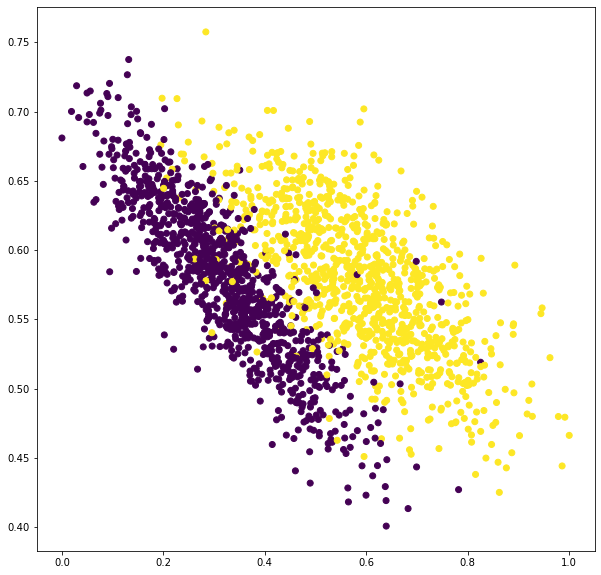

In [1428]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(0, 1.1, 0.01),
                       np.arange(0, 1.1, 0.01))
#
X_train = my_normalize(X_train)
y_train = my_normalize(y_train)
X_test = my_normalize(X_test)
y_test = my_normalize(y_test)

y_test[y_test == 0] = -1
y_train[y_train == 0] = -1



plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [1429]:
def calculate_value(theta, pX):
    return pX @ theta


def label_data(data, mean):
    ans = list()
    for x in data:
        if x >= mean:
            ans.append(1.0)
        else:
            ans.append(-1.0)
    return np.asarray(ans)

start_analytical = time.perf_counter()
for i in range(repeats):
    my_ridge = normal_equation_ridge_regression(X_train, y_train, 1)
analytical_time = time.perf_counter() - start_analytical

my_ridge = my_ridge.reshape((3,1))


y_predicted = f_wielomian(my_ridge, np.c_[xx.ravel(), yy.ravel()])

mean = np.mean(y_predicted)

y_predicted = label_data(y_predicted, 0)


y_predicted = y_predicted.reshape(xx.shape)


# # y_predicted2 = label_data(y_predicted2, mean)
#
# conf = confusion_matrix(y_test, predict2)
# print("NIEKOX\n", conf, accuracy_score(y_test, predict2))
#
# huj = label_data(y_predicted, mean)
# conf = confusion_matrix(y_test, huj)
# print("KOX \n",conf, accuracy_score(y_test, huj))
# conf



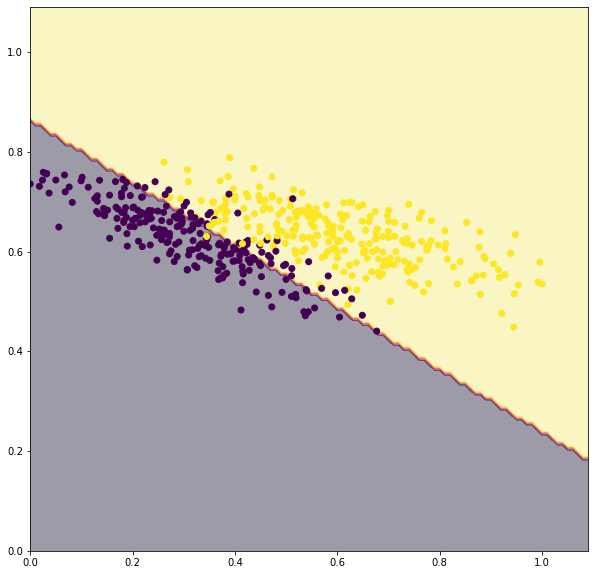

In [1430]:
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, y_predicted, alpha=0.4, cmap='inferno')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

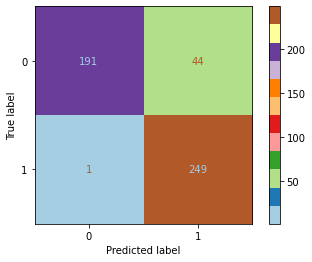

In [1431]:
values = f_wielomian(my_ridge, X_test)
values = label_data(values, 0)
cm_analytical = confusion_matrix(y_test, values)
tp_analytical = cm_analytical[0][0]
fp_analytical = cm_analytical[0][1]
tn_analytical = cm_analytical[1][1]
fn_analytical = cm_analytical[1][0]
ConfusionMatrixDisplay(cm_analytical).plot(cmap='Paired')

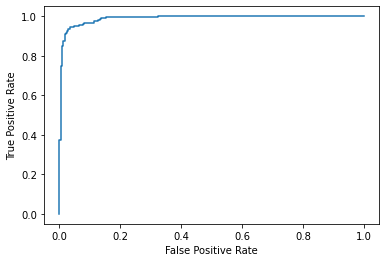

In [1432]:
fpr, tpr, roc_auc = roc_curve(y_test, f_wielomian(my_ridge, X_test))

rok_analitic = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_analitic.plot()

In [1433]:
model_ridge = RidgeClassifier(copy_X=True)

start_ridge = time.perf_counter()
for i in range(repeats):
    model_ridge.fit(X_train, y_train)
ridge_time = time.perf_counter() - start_ridge

predict = model_ridge.predict(c_[xx.ravel(), yy.ravel()])

predict = predict.reshape(xx.shape)

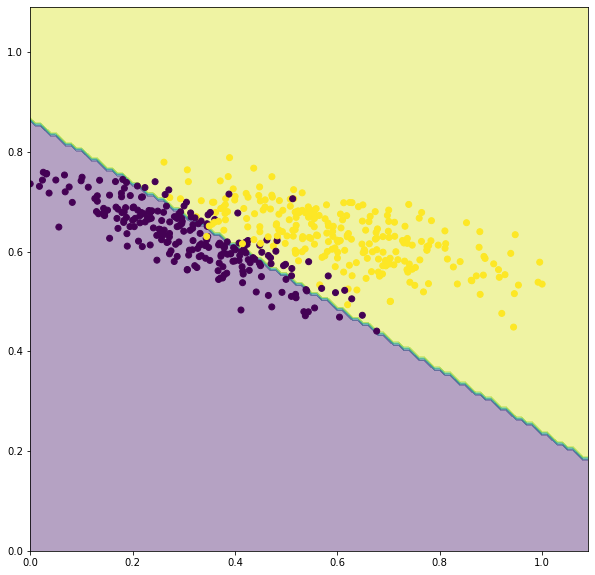

In [1434]:
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, predict, alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

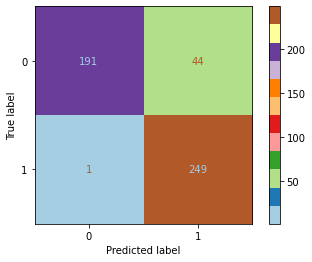

In [1435]:
cm_model = confusion_matrix(y_test, model_ridge.predict(X_test))
tp_model = cm_model[0][0]
fp_model = cm_model[0][1]
tn_model = cm_model[1][1]
fn_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='Paired')

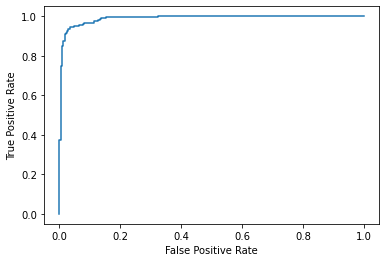

In [1436]:
fpr, tpr, roc_auc = roc_curve(y_test, model_ridge.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

### Podsumowanie

Czas wykonania analityczna: 0.017762999996193685
Czas wykonania ridge: 0.1592971999925794
Czulosc analityczna: 0.9947916666666666
Czulosc ridge: 0.9947916666666666
Swoistosc analityczna: 0.8498293515358362
Swoistosc ridge: 0.8498293515358362

Macierz pomylek analityczny
 [[191  44]
 [  1 249]]

Macierz pomylek model
 [[191  44]
 [  1 249]]


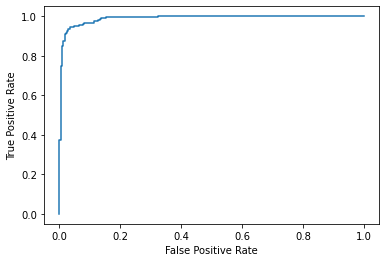

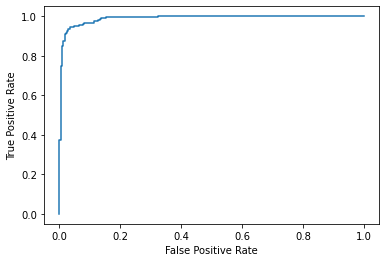

In [1437]:
print("Czas wykonania analityczna:", analytical_time)
print("Czas wykonania ridge:", ridge_time)

print("Czulosc analityczna:", tp_analytical/(tp_analytical + fn_analytical))
print("Czulosc ridge:", tp_model/(tp_model + fn_model))

print("Swoistosc analityczna:", tn_analytical/(tn_analytical + fp_analytical))
print("Swoistosc ridge:", tn_model/(tn_model + fp_model))

print("\nMacierz pomylek analityczny\n",cm_analytical)
print("\nMacierz pomylek model\n",cm_model)

rok_analitic.plot()
rok_model.plot()

### Dodatkowe

In [1438]:
print(model_ridge.coef_)
print(my_ridge)
ones = np.ones((len(X_test), 1))        # results in array( [ [1],..,[1] ] )
print(calculate_ridge(c_[ones,X_test], y_test, 1))
model_new = Ridge(1)
model_new.fit(X_train, y_train)
print(model_new.coef_)

[[4.93668022 7.90817282]]
[[-6.82349292]
 [ 4.93668022]
 [ 7.90817282]]
[-7.6628457   7.2987915   6.90401058]
[4.93668022 7.90817282]
